### edges problem

Let $G = (V,E,s)$ be a signed graph and $k$ a positive scalar satisfying $k \in \{1, \ldots, n\}$.

An edge $e \in E$ is called negative if $s(e) = −1$ and positive if $s(e) = +1$. 

Let $E^{-}$ and $E^{+}$ denote, respectively, the sets of negative and positive edges in a signed graph. 

For a vertex set $S \subseteq V$ , let $E[S] = \{ (i,j) \in E \ | \ i,j \in S \}$ denote the subset of edges induced by $S$.

Let $S[i]$ the partition $i$ the $G$.

$
x_{v,i} = 
\begin{cases}
1, & \text{ if } v \in S[i] \\
0, & \text{otherwise}. 
\end{cases} 
\forall v \in V(G),\forall i \in [k]
$

$
y_{uv} = 
\begin{cases}
1, & \text{ if } (u,v) \text{ is removed} \\
0, & \text{ otherwise.} 
\end{cases} 
\forall (u,v) \in E(G)
$

$$
\begin{align}
\min \quad & \sum\limits_{uv \in E(G)} y_{uv} & \\
\text{s.t} \quad & \sum_{i \in [k]} x_{v,i} \geq 1 & \forall v \in V(G)  \\
& x_{ui} + x_{vi} \leq 1 + y_{uv} & \forall uv \in E^{-}(G), \forall i \in [k] \\
& x_{ui} \geq x_{vi} - y_{uv} & \forall uv \in E^{+}(G), \forall i \in [k] \\
& x_{vi} \geq x_{ui} - y_{uv} & \forall uv \in E^{+}(G), \forall i \in [k] \\
& x_{vi} \in \{0,1\} & \forall v \in V(G), \forall i \in [k] \\
& y_{vu} \in \{0,1\} & \forall uv \in E(G) 
\end{align}
$$

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp

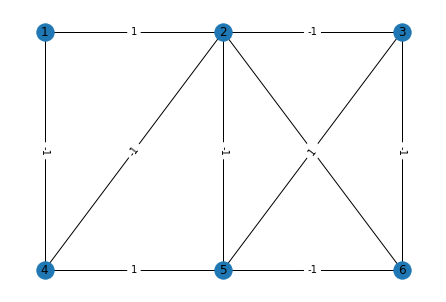

In [95]:
G = nx.Graph()
#G.add_nodes_from([1,2,3,4,5,6])

edges = [(1,2,+1), (1,4,-1), (2,3,-1), (2,4,-1), (2,5,-1), (2,6,+1), (3,5,+1), (3,6,-1), (4,5,+1), (5,6,-1)]

G.add_weighted_edges_from(edges)

#nx.draw_planar(G, with_labels = "True")

pos = {1:(0,0), 2:(2,0), 3:(4,0), 4:(0,-1), 5:(2,-1), 6:(4,-1)}

nx.draw(G, pos, with_labels="True")

edge_labels = nx.get_edge_attributes(G, "weight")

nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

In [107]:
def edgesEN(G):
    EP = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    EN = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0]

    return EP, EN

In [108]:
def setVK(G,k):
    nodes = G.nodes()
    vk = []
    for i in nodes:
        for j in range(k):
            a = (i,j)
            vk.append(a)

    return vk

In [109]:
EP, EN = edgesEN(G)

In [110]:
print("EN = ", EN)
print("EP = ", EP)

EN =  [(1, 4), (2, 3), (2, 4), (2, 5), (3, 6), (5, 6)]
EP =  [(1, 2), (2, 6), (4, 5), (3, 5)]


In [111]:
k = 3 
VK = setVK(G,k)
print(VK)

[(1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (4, 0), (4, 1), (4, 2), (3, 0), (3, 1), (3, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2)]


In [112]:
# clear graph
G.clear()

In [113]:
def read_instance(instance):
    with open(instance, 'r') as file: 
        lines = file.readlines()

    lines = [a.strip() for a in lines]

    values = lines[0].split()
    n, m = int(values[0]), int(values[1])

    #print("n =", n)
    #print("m =", m)

    G = nx.Graph()

    for k in range(n):
        G.add_node(k)

    for e in range(1,m+1):
        values = lines[e].split()
        i, j, val = int(values[0]), int(values[1]), int(values[2])
        G.add_edge(i, j, weight=val)

    return G


In [181]:
def plotGraph(G):
    seed = 20532
    plt.figure(figsize=(25, 20))
    #pos=nx.spring_layout(G)
    #pos=nx.random_layout(G)
    #pos=nx.circular_layout(G)
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [182]:
def edges_mip_formulation(G, k, VK, EP, EN):

    nodes = G.nodes()
    edges = G.edges()
    K = range(k)
    
    method = "mip"

    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges,vtype=gp.GRB.BINARY, name="y")
        x = model.addVars(VK,vtype=gp.GRB.BINARY, name="x")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += 1*y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints
 
    for v in nodes:
        constr = 0
        for i in K:
            constr += x[(v,i)] 
        model.addConstr(constr >= 1.0, "constr2")

    for e in EN:
        for i in K:
            model.addConstr(x[(e[0],i)] + x[(e[1],i)] <= 1 + y[(e[0],e[1])], "constr3")


    for e in EP:
        for i in K:
            model.addConstr(x[(e[0],i)] >= x[(e[1],i)] - y[(e[0],e[1])], "constr4")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[1],i)] >= x[(e[0],i)] - y[(e[0],e[1])], "constr5")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')


    model.write("edges_mip.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    xval = {}
    for v in VK:
        xval[v] = x[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    Ex = []
    for key, value in xval.items():
        #print(key, value)
        if value > 0.5:# and key[0] != key[1]:
            #print(key, value)
            Ex.append(key)

    Ey = []
    for key, value in yval.items():
        #print(key, value)
        if value > 0.5:# and key[0] != key[1]:
            #print(key, value)
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey

In [183]:
#random_n20_k2_pos30_neg5_err5_1
#random_n20_k2_pos30_neg5_err5_2
#random_n20_k2_pos30_neg5_err5_3
#random_n20_k2_pos30_neg5_err5_4
#random_n20_k2_pos30_neg5_err5_5

#random_n60_k2_pos30_neg5_err5_1
#random_n60_k2_pos30_neg5_err5_2
#random_n60_k2_pos30_neg5_err5_3
#random_n60_k2_pos30_neg5_err5_4
#random_n60_k2_pos30_neg5_err5_5

# random_n60_k3_pos30_neg5_err5_1

# random_n60_k4_pos30_neg5_err5_1

# random_n60_k5_pos30_neg5_err5_1

instance = f"../data/kmbs/instances/RANDOM/random_n60_k3_pos30_neg5_err5_1.g"

k = 3
G = read_instance(instance)

n = G.number_of_nodes()
m = G.number_of_edges()

print("n =", n)
print("m =", m)

n = 60
m = 236


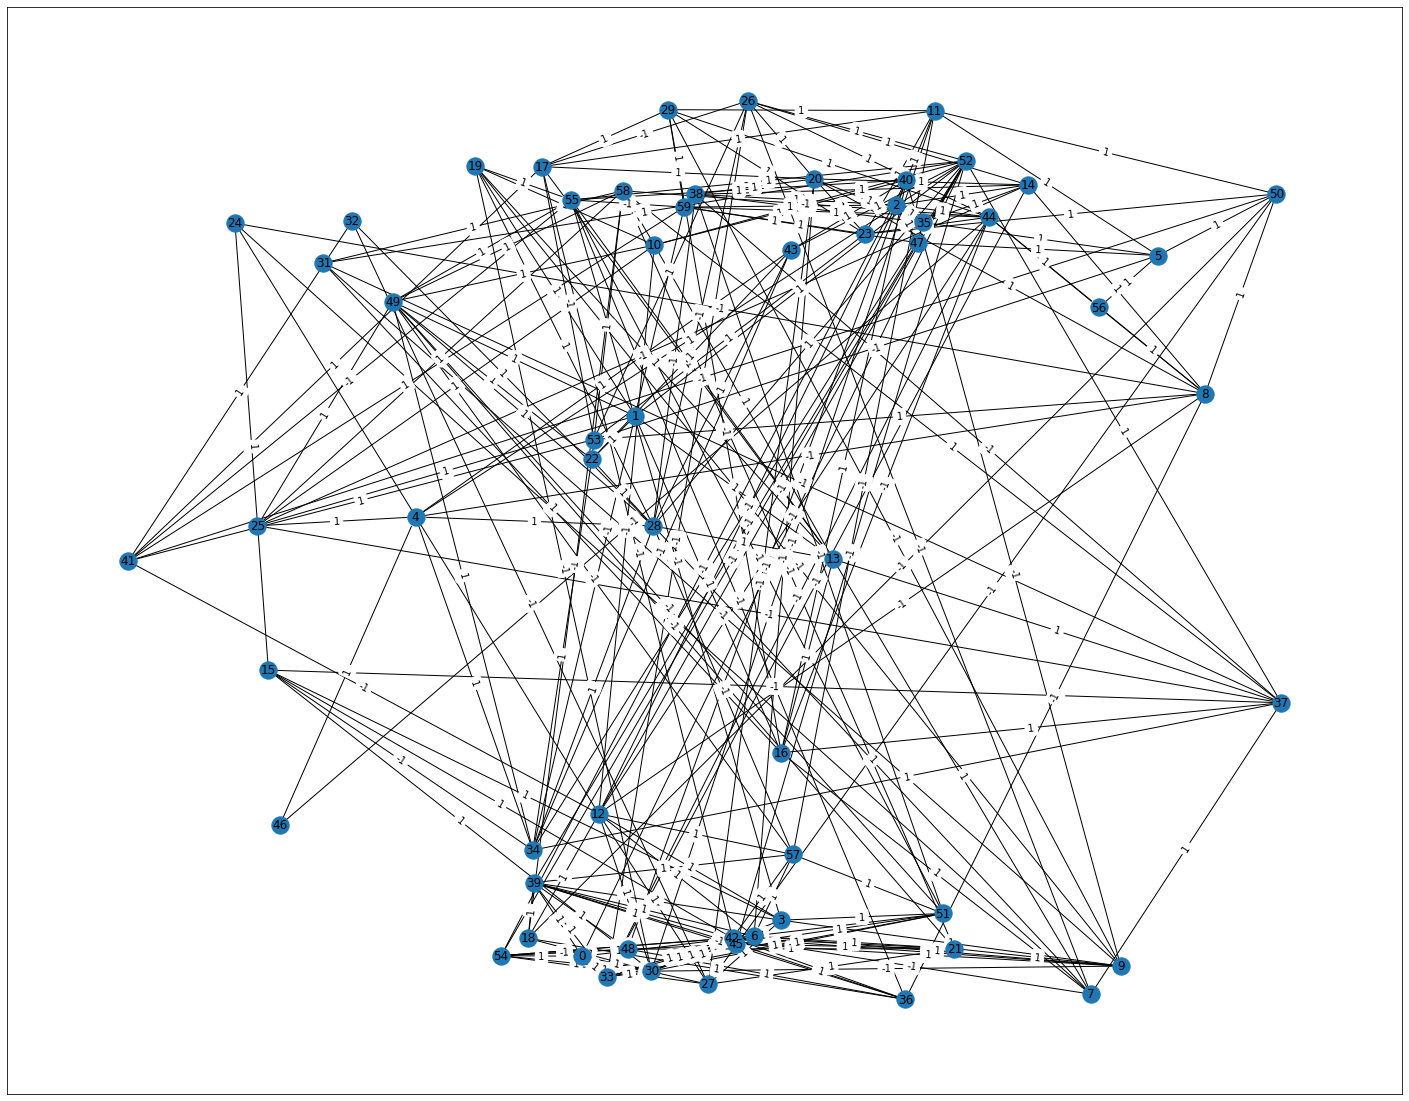

In [184]:
plotGraph(G)

In [195]:
EP, EN = edgesEN(G)
#print(len(EP),len(EN))

VK = setVK(G,k)
#print(VK)

HP = nx.Graph()
HN = nx.Graph()

HP.add_nodes_from(G)
HN.add_nodes_from(G)

#HP = G.edge_subgraph(EP)
#HN = G.edge_subgraph(EN)

HP.add_edges_from(EP)
HN.add_edges_from(EN)

print(f"G nodes = {G.number_of_nodes()}")
print(f"G edges = {G.number_of_edges()}")

print(f"HP nodes = {HP.number_of_nodes()}")
print(f"HP edges = {HP.number_of_edges()}")

print(f"HN nodes = {HN.number_of_nodes()}")
print(f"HN edges = {HN.number_of_edges()}")

#print(HP.edges())

G nodes = 60
G edges = 236
HP nodes = 60
HP edges = 167
HN nodes = 60
HN edges = 69


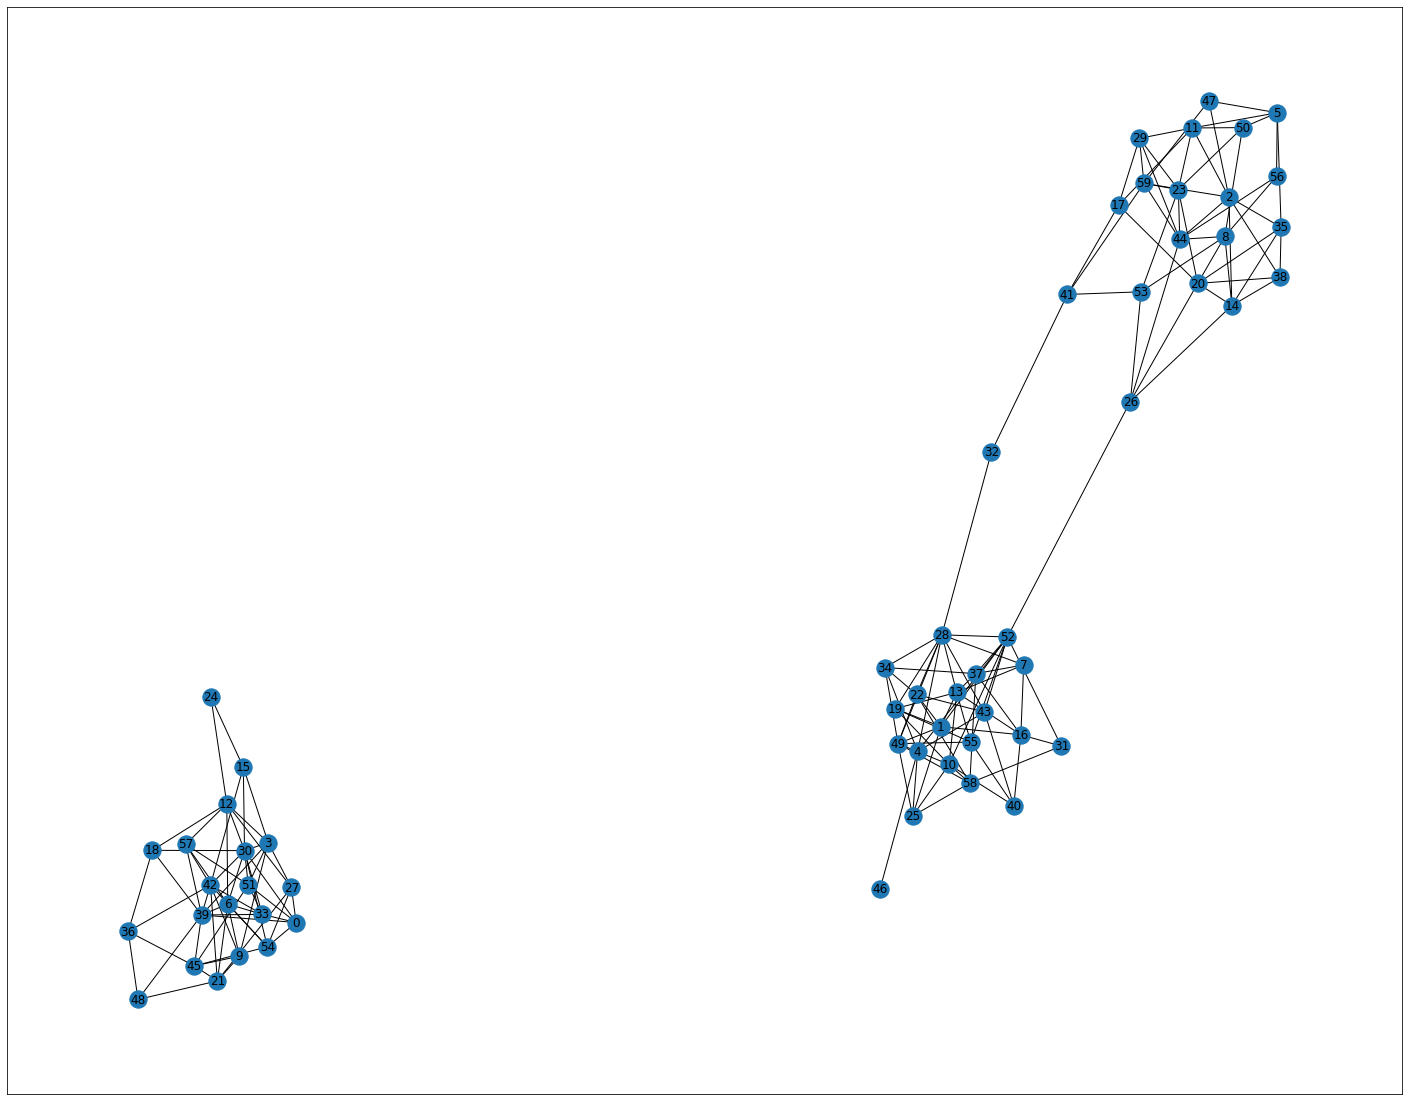

In [190]:
plotGraph(HP)

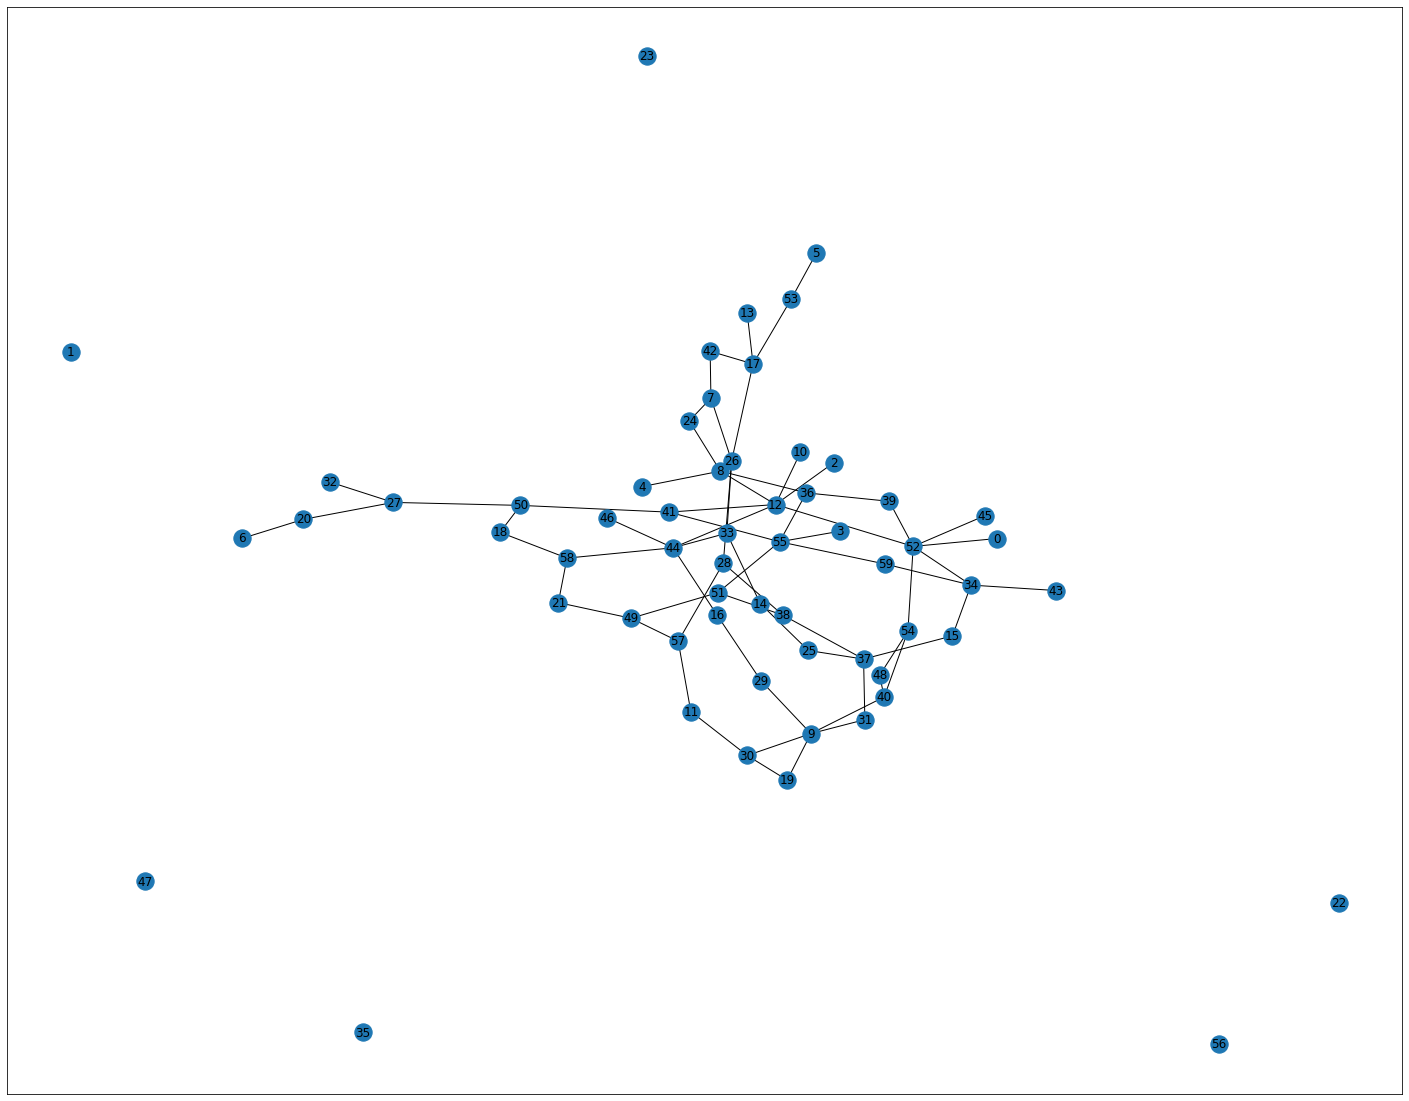

In [191]:
plotGraph(HN)

In [192]:
objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey = edges_mip_formulation(G, k, VK, EP, EN)
    
print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)


ub =  13.0
time =  0.15232300758361816
status =  1
lb =  13.0
gap =  0.0
nodes =  7.0


In [143]:
print(Ex)

[(0, 2), (1, 1), (2, 0), (3, 2), (4, 1), (5, 0), (6, 2), (7, 1), (8, 0), (9, 2), (10, 1), (11, 0), (12, 2), (13, 1), (14, 0), (15, 2), (16, 1), (17, 0), (18, 2), (19, 1), (20, 0), (21, 2), (22, 1), (23, 0), (24, 2), (25, 1), (26, 0), (27, 2), (28, 1), (29, 0), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 0), (36, 2), (37, 1), (38, 0), (39, 2), (40, 1), (41, 0), (42, 2), (43, 1), (44, 0), (45, 2), (46, 1), (47, 0), (48, 2), (49, 1), (50, 0), (51, 2), (52, 1), (53, 0), (54, 2), (55, 1), (56, 0), (57, 2), (58, 1), (59, 0)]


In [144]:
print(Ey)

[(5, 53), (9, 30), (17, 26), (17, 53), (25, 37), (26, 52), (31, 37), (32, 41), (34, 43), (34, 52), (36, 39), (41, 50), (48, 54)]


In [145]:
for i in range(k):
    print(f"particao {i}: ", end="")
    for v in Ex:
        if v[1] == i:
            print(v[0], end=", ")
    print()

particao 0: 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 35, 38, 41, 44, 47, 50, 53, 56, 59, 
particao 1: 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 32, 34, 37, 40, 43, 46, 49, 52, 55, 58, 
particao 2: 0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 


In [146]:
partition = []
for i in range(k):
    a = []
    for v in Ex:
        if v[1] == i:
            a.append(v[0])
    partition.append(set(a))
    
#partition

In [147]:
nx.community.is_partition(G, partition)

True

In [158]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

#partition_map

In [159]:
partition_map[0] == partition_map[42]

True

In [160]:
color_map = []
for node in G:
    if partition_map[node] == 0:
        color_map.append('gray')
    elif partition_map[node] == 1:
        color_map.append('green')
    else:
        color_map.append('yellow')

#node_colors = [partition_map[n] for n in G.nodes]

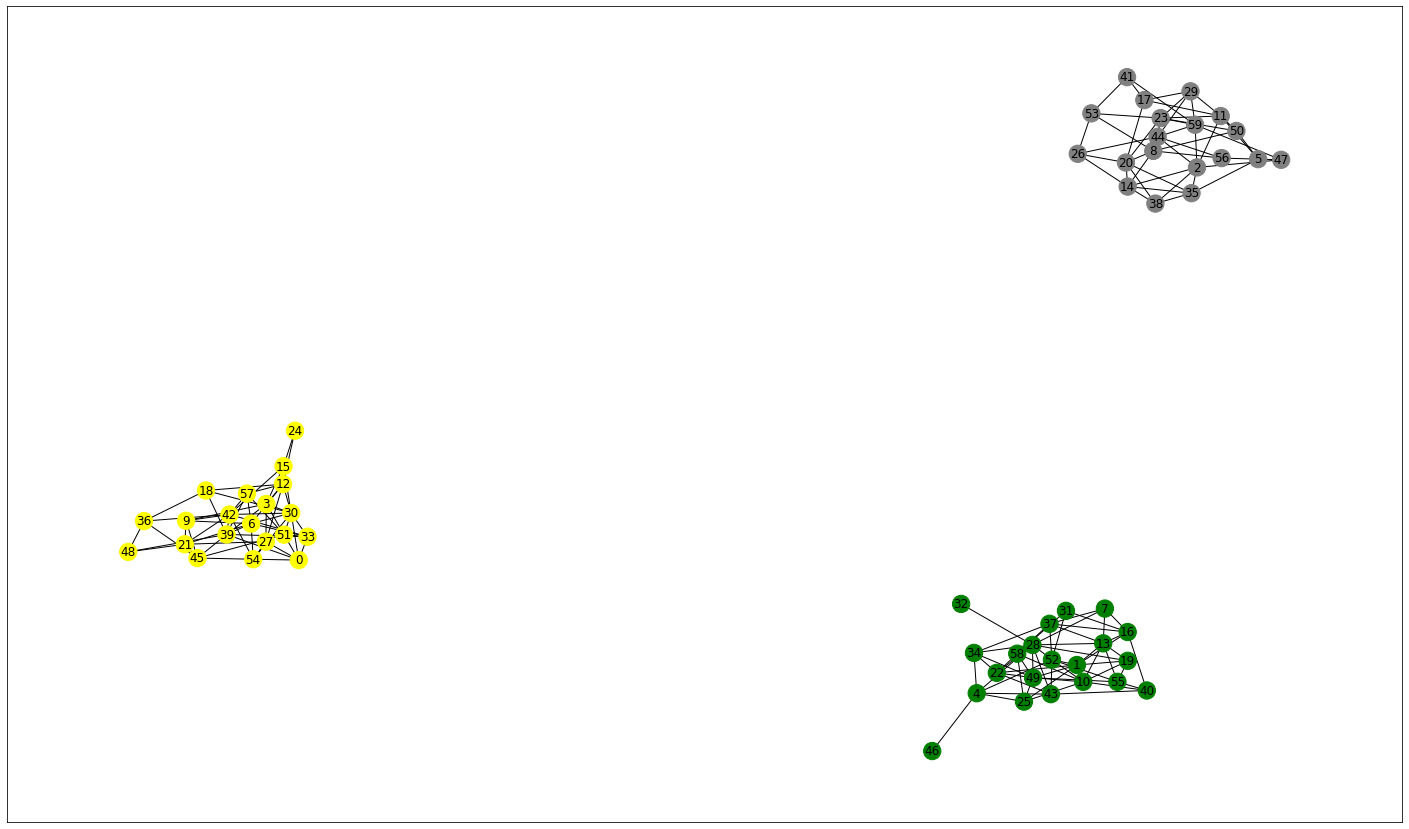

In [179]:
ebunch = Ey
HP.remove_edges_from(ebunch)

seed = 20532
plt.figure(figsize=(25, 15))        
pos = nx.spring_layout(HP, seed=seed)
nx.draw_networkx(HP, pos, node_size=300, node_color=color_map, with_labels=True)
plt.show()

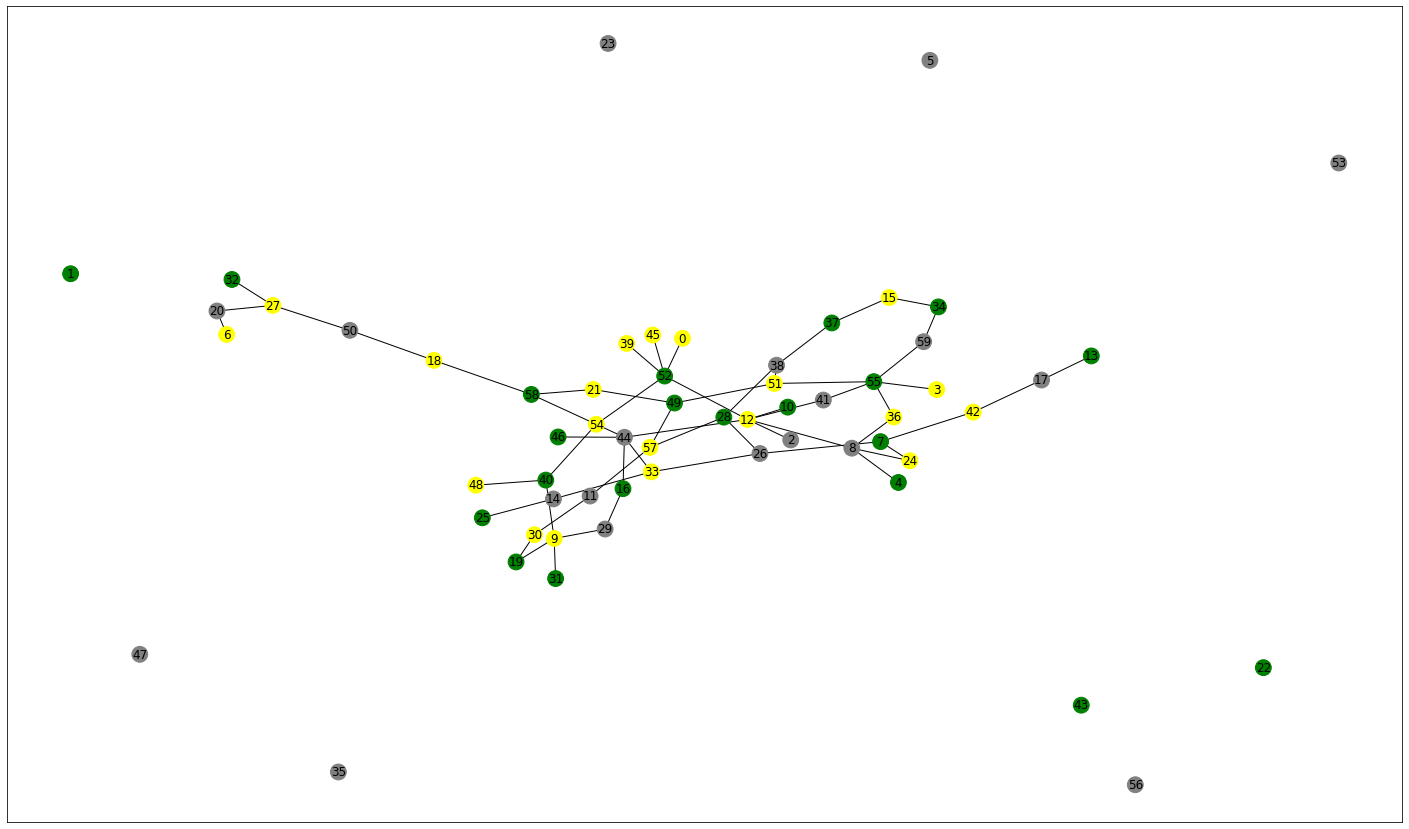

In [180]:
ebunch = Ey
HN.remove_edges_from(ebunch)

seed = 20532
plt.figure(figsize=(25, 15))        
pos = nx.spring_layout(HN, seed=seed)
nx.draw_networkx(HN, pos, node_size=250, node_color=color_map, with_labels=True)
plt.show()

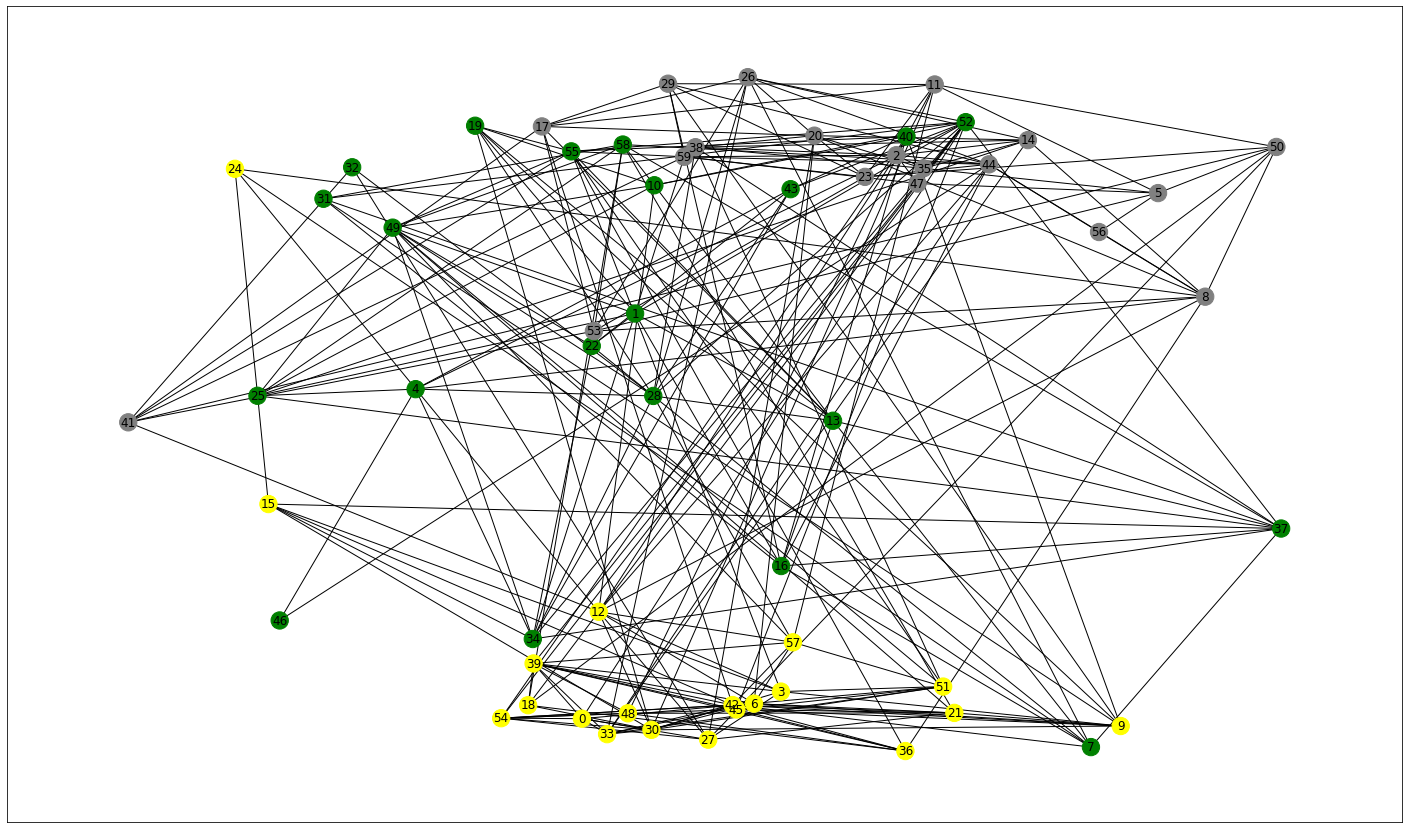

In [196]:
seed = 20532
plt.figure(figsize=(25, 15))        
pos = nx.spring_layout(G, seed=seed)
nx.draw_networkx(G, pos, node_size=300, node_color=color_map, with_labels=True)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()